In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
TS_DATASET_FOLDER = os.path.join('..', 'dataset')
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, 'preprocessed_traces')
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, 'preproc_ts.df')

TARGET = 'statement'
TRACES = 'syllables_02_sc'

In [3]:
df = pd.read_csv(DF_PREPROC_FILE).drop(columns=['Unnamed: 0'])
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,path,sex,begin_s,end_s,fourier_coeffs,filtered_fourier_coeffs,syll_0_start_index,syll_1_start_index,syll_2_start_index,syll_3_start_index,syll_4_start_index,syll_5_start_index,syll_6_start_index,syll_7_start_index
0,speech,surprised,strong,dogs,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.007500,2.498167,[1.0788441e-05 3.7551079e-02 3.6168553e-02 ......,[1.0788441e-05 3.7551045e-02 3.6168423e-02 ......,0,2872,3920,4536,5536,6480,7136,8936
1,speech,surprised,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.024167,2.357167,[8.6426735e-06 1.0938305e-02 7.4250461e-03 ......,[8.6426735e-06 1.0938293e-02 7.4250125e-03 ......,0,1544,2528,4032,5224,5984,6712,7992
2,speech,angry,normal,dogs,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.029333,2.467500,[1.1563301e-05 4.1558143e-02 2.8845785e-02 ......,[1.15633011e-05 4.15581055e-02 2.88456734e-02 ...,0,2992,4368,4912,5896,6768,7400,8624
3,speech,fearful,normal,dogs,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.030500,2.710000,[2.0563602e-06 1.1770763e-02 5.6602592e-03 ......,[2.0563602e-06 1.1770754e-02 5.6602429e-03 ......,0,4576,5064,6240,7544,8248,8784,10072
4,speech,fearful,strong,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.047667,3.127167,[6.9618225e-05 1.3387279e-02 8.0524459e-02 ......,[6.9618225e-05 1.3387272e-02 8.0524310e-02 ......,0,1984,2504,3648,5176,8320,10256,12472


In [4]:
traces_dict = {}
files = os.listdir(TS_PREPROC_FOLDER)

for file in files:

    if file.endswith('.npy'):
        file_path = os.path.join(TS_PREPROC_FOLDER, file)
        # dictionary keys are the file names
        key = os.path.splitext(file)[0]
        # load array
        traces_dict[key] = np.load(file_path, allow_pickle=True)

traces_dict.keys()

dict_keys(['clean_trace', 'syllables_1_ts', 'std_phon_trace', 'syllables_02_sc', 'spectral_mode', 'syllables_3_ts', 'syllables_5_ts', 'syllables_0_ts', 'syllables_2_ts', 'spectral_centroid', 'syllables_fourier', 'traces_fourier', 'syllables_02_STFT', 'syllables_6_ts', 'full_stft', 'syllables_4_ts'])

In [5]:
traces = traces_dict[TRACES]
traces.shape

(2452, 27)

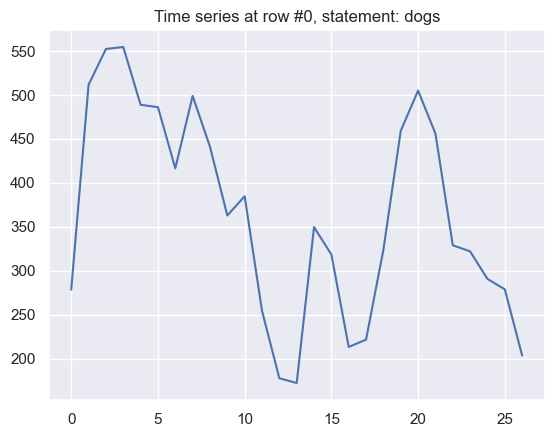

In [6]:
index = 0
statement = df['statement'][index]
plt.plot(traces[index])
plt.title(f'Time series at row #{index}, statement: {statement}')
plt.show()

In [7]:
# sort by actors
sorted_indices = df['actor'].argsort()
df = df.iloc[sorted_indices].reset_index(drop=True)

traces = traces[sorted_indices]

traces

array([[ 278.39014204,  511.49379894,  552.14232442, ...,  290.54333148,
         278.71819257,  203.40850852],
       [1357.80416509,  315.95323363,  310.18838932, ...,  300.36618306,
         345.33438658,  361.24902668],
       [ 290.76600877,  311.04120042,  296.83492546, ...,  468.56052654,
         459.1021669 ,  834.85383644],
       ...,
       [ 423.72971392,  445.93155062,  468.20092124, ...,  585.25235089,
         336.2925077 ,  418.15274972],
       [ 407.79040927,  601.32524285,  667.11654184, ...,  374.34963697,
         417.56471368,  365.99495549],
       [ 378.91501739,  461.07143328,  430.3820086 , ...,  467.02638076,
         446.4945006 ,  451.47057441]])

In [8]:
from sklearn.model_selection import train_test_split

split_index = df[df['actor'] == 'actor_19'].index[0]

X_train = traces[:split_index]
X_test = traces[split_index:]

y_train = df[TARGET][:split_index].to_numpy()
y_test = df[TARGET][split_index:].to_numpy()

X_train_v, X_valid, y_train_v, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=100)

X_train_v.shape, X_valid.shape, X_test.shape, y_train_v.shape, y_valid.shape, y_test.shape

((1462, 27), (366, 27), (624, 27), (1462,), (366,), (624,))

In [9]:
np.any(np.isinf(traces))

False

# Shapelets

In [10]:
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict

n_ts, ts_size = X_train.shape
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts, ts_sz=ts_size, n_classes=2, l=0.01, r=30)
shapelet_sizes

{1: 4,
 2: 4,
 3: 4,
 4: 4,
 5: 4,
 6: 4,
 7: 4,
 8: 4,
 9: 4,
 10: 4,
 11: 4,
 12: 4,
 13: 4,
 14: 4,
 15: 4,
 16: 4,
 17: 4,
 18: 4,
 19: 4,
 20: 4,
 21: 4,
 22: 4,
 23: 3,
 24: 3,
 25: 3,
 26: 3,
 27: 3}

In [11]:
# -------- Shapelets extraction --------

# shapelets extraction model
shapelet_model = ShapeletModel(n_shapelets_per_size=shapelet_sizes, batch_size=16, max_iter=100)
shapelet_model.fit(X_train, y_train)

# shapelets extraction
shapelets = shapelet_model.shapelets_
shapelets

/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


array([array([[458.61981201]]), array([[458.46343994]]),
       array([[458.62756348]]), array([[458.54666138]]),
       array([[418.11056519],
              [386.26022339]]), array([[426.92462158],
                                       [343.63354492]]),
       array([[427.98580933],
              [396.95828247]]), array([[386.02975464],
                                       [404.76251221]]),
       array([[466.015625  ],
              [341.33621216],
              [329.36260986]]), array([[470.546875  ],
                                       [335.32141113],
                                       [292.66503906]]),
       array([[473.38027954],
              [341.50878906],
              [321.73168945]]), array([[420.60681152],
                                       [317.32748413],
                                       [289.19152832]]),
       array([[307.73052979],
              [350.59185791],
              [360.92471313],
              [456.36288452]]), array([[291.55831909],
   

In [12]:
# -------- Shapelets distances computation --------

X_train_transformed = shapelet_model.transform(X_train)
X_test_transformed = shapelet_model.transform(X_test)

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

# -------- Hyperparameters tuning --------

param_grid = {
    'n_neighbors': np.arange(2, 50),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'minkowski'],
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True,
)

grid.fit(X_train_transformed, y_train)
print(grid.best_params_, grid.best_score_)

{'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'distance'} 0.8966620256007186


In [14]:
# -------- Classification --------

knn = grid.best_estimator_
y_pred = knn.predict(X_test_transformed)

In [15]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.8894230769230769
F1-score [0.89302326 0.88557214]
              precision    recall  f1-score   support

        dogs       0.86      0.92      0.89       312
        kids       0.92      0.86      0.89       312

    accuracy                           0.89       624
   macro avg       0.89      0.89      0.89       624
weighted avg       0.89      0.89      0.89       624

